In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [20]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        super(FS, self).__init__()
        self.num_params = num_params
        self.indices = torch.arange(1, num_params + 1).float()

        if num_params == 4:
            h = torch.tensor([6.0247, 3.0090, 1.5470, 1.0945])
            d = torch.tensor([6.1718, 3.0962, 1.5492, 0.7664])
            T = torch.tensor([5.8070, 2.8584, 1.3577, 0.5687])
        elif num_params == 8:
            h = torch.tensor([3.6760, 2.8168, 2.3811, 1.3095, 0.8152, 0.3878, 0.1751, 2.4152])
            d = torch.tensor([3.6922, 2.9805, 2.4332, 1.3228, 0.8048, 0.3861, 0.1863, 0.1023])
            T = torch.tensor([8.2595, 3.5255, 2.5539, 1.7761, 0.9528, 0.5461, 0.3573, 0.2881])
        elif num_params == 12:
            h = torch.tensor([1.1299, 6.8735, 4.4682, 2.0329, 1.3388, 0.7357, 0.7149, 0.4261, 0.6461, 0.4154, 0.2179, 0.3444])
            d = torch.tensor([-0.2083,  7.0264,  4.6516,  2.1096,  1.3740,  0.7480,  0.6828,  0.3809, 0.4077,  0.2240,  0.1159,  0.0536])
            T = torch.tensor([-3.5203,  5.9076,  4.0212,  1.8142,  0.9658,  0.3212, -0.0740, -0.4722, -0.7314, -1.2238, -1.3265, -1.4648])
        elif num_params == 16:
            h = torch.tensor([0.5602, 0.3329, 1.2282, 1.4916, 1.0170, 1.0777, 0.9202, 1.2722, 2.8685, 1.3212, 0.8411, 0.3989, 0.1870, 0.0936, 0.0616, 1.1349])
            d = torch.tensor([0.3161,  0.2175, -0.2093,  1.6195,  1.0840,  1.1121,  0.9249,  1.2900, 2.8708,  1.3277,  0.8375,  0.3912,  0.1875,  0.0973,  0.0640,  0.0406])
            T = torch.tensor([0.0984, -0.0835, -3.5130,  0.6933,  0.1460,  0.0137,  0.9415,  0.2020, 1.2894, -0.2560, -0.7142, -1.1954, -1.3832, -1.4649, -1.4901, -1.5134])

        # if self.num_params == 4:
        #     self.h = 0.6408 * self.indices**2 - 4.8293 * self.indices + 10.186
        #     self.d = 0.5732 * self.indices**2 - 4.6423 * self.indices + 10.203
        #     self.T = 0.5399 * self.indices**2 - 4.4211 * self.indices + 9.6514
        # elif self.num_params == 8:
        #     self.h = -1.378 * torch.log(self.indices) + 3.5742
        #     self.d = -1.92 * torch.log(self.indices) + 4.0338
        #     self.T = -3.663 * torch.log(self.indices) + 7.1379
        # elif self.num_params == 12:
        #     self.h = 0.0289 * self.indices**2 - 0.7486 * self.indices + 4.9117
        #     self.d = 0.0078 * self.indices**2 - 0.4573 * self.indices + 4.0149
        #     self.T = -0.0495 * self.indices**2 + 0.3057 * self.indices + 1.0462
        # elif self.num_params == 16:
        #     self.h = -0.018 * self.indices**2 + 0.2526 * self.indices + 0.3753
        #     self.d = -0.0284 * self.indices**2 + 0.3955 * self.indices + 0.0063
        #     self.T = -0.021 * self.indices**2 + 0.1795 * self.indices - 0.0105

        self.h = nn.Parameter(h + torch.normal(0, 0.1, size=h.size()))
        self.d = nn.Parameter(d + torch.normal(0, 0.1, size=d.size()))
        self.T = nn.Parameter(T + torch.normal(0, 0.1, size=T.size()))

        # self.h = nn.Parameter(h)
        # self.d = nn.Parameter(d)
        # self.T = nn.Parameter(T)

        # self.h = nn.Parameter(self.h)
        # self.d = nn.Parameter(self.d)
        # self.T = nn.Parameter(self.T)

        #Define FS parameters (now as learnable parameters)
        #self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        #self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        #self.T = nn.Parameter(torch.randn(num_params))

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        noisy_h = self.h + torch.normal(0, 0.1, size=self.h.size(), device=self.h.device)
        noisy_d = self.d + torch.normal(0, 0.1, size=self.d.size(), device=self.d.device)
        noisy_T = self.T + torch.normal(0, 0.1, size=self.T.size(), device=self.T.device)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - noisy_T[t]
            z = spike_function(v_scaled)
            temp_out += z * noisy_d[t]
            v = v - z * noisy_h[t]

        return temp_out

# Swish

K=4

Epoch 1/20000, Loss: 0.11059215664863586
Epoch 1001/20000, Loss: 0.06943182647228241
Epoch 2001/20000, Loss: 0.07349593937397003
Epoch 3001/20000, Loss: 0.06630434840917587
Epoch 4001/20000, Loss: 0.05641694366931915
Epoch 5001/20000, Loss: 0.056834325194358826
Epoch 6001/20000, Loss: 0.053032323718070984
Epoch 7001/20000, Loss: 0.08040675520896912
Epoch 8001/20000, Loss: 0.05428034067153931
Epoch 9001/20000, Loss: 0.044695381075143814
Epoch 10001/20000, Loss: 0.05637681484222412
Epoch 11001/20000, Loss: 0.04309430718421936
Epoch 12001/20000, Loss: 0.08729904145002365
Epoch 13001/20000, Loss: 0.049189288169145584
Epoch 14001/20000, Loss: 0.05929653346538544
Epoch 15001/20000, Loss: 0.050589825958013535
Epoch 16001/20000, Loss: 0.13438089191913605
Epoch 17001/20000, Loss: 0.05906051769852638
Epoch 18001/20000, Loss: 0.05196356773376465
Epoch 19001/20000, Loss: 0.04480559751391411
Loss values: [0.11059215664863586, 0.06975016742944717, 0.11138192564249039, 0.07979882508516312, 0.09490384

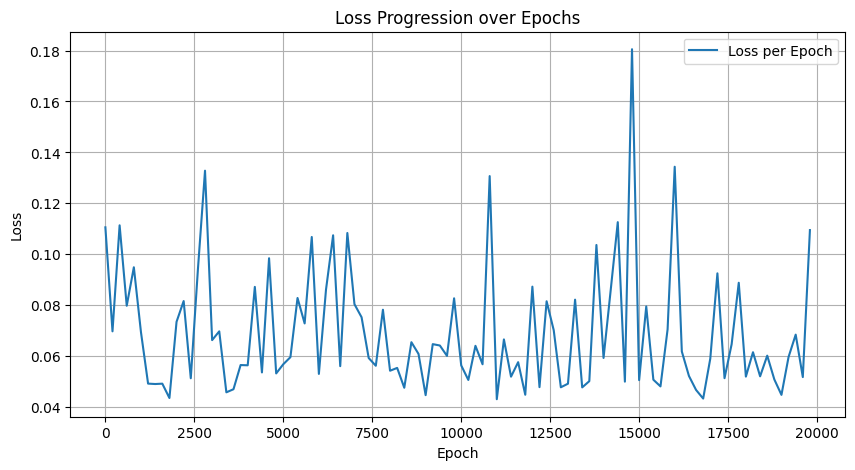

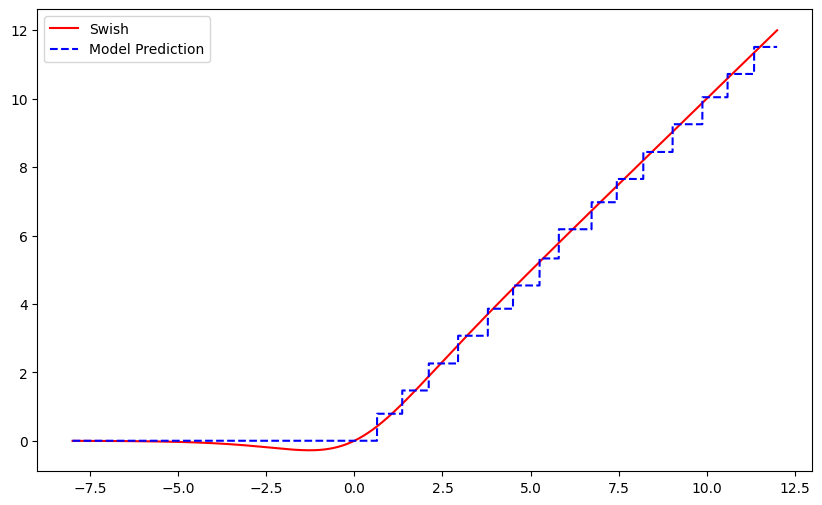

In [21]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 0.03598947450518608
Epoch 1001/20000, Loss: 0.06850192695856094
Epoch 2001/20000, Loss: 0.03437751531600952
Epoch 3001/20000, Loss: 0.024322817102074623
Epoch 4001/20000, Loss: 0.03264927864074707
Epoch 5001/20000, Loss: 0.03791339695453644
Epoch 6001/20000, Loss: 0.06128735467791557
Epoch 7001/20000, Loss: 0.03021003119647503
Epoch 8001/20000, Loss: 0.0941171944141388
Epoch 9001/20000, Loss: 0.042586103081703186
Epoch 10001/20000, Loss: 0.0798482596874237
Epoch 11001/20000, Loss: 0.04781205579638481
Epoch 12001/20000, Loss: 0.020945435389876366
Epoch 13001/20000, Loss: 0.02385707013309002
Epoch 14001/20000, Loss: 0.02633296139538288
Epoch 15001/20000, Loss: 0.055974461138248444
Epoch 16001/20000, Loss: 0.032911088317632675
Epoch 17001/20000, Loss: 0.0211032684892416
Epoch 18001/20000, Loss: 0.029679536819458008
Epoch 19001/20000, Loss: 0.02223929762840271
Loss values: [0.03598947450518608, 0.03099905699491501, 0.021170422434806824, 0.0902649387717247, 0.0357725694

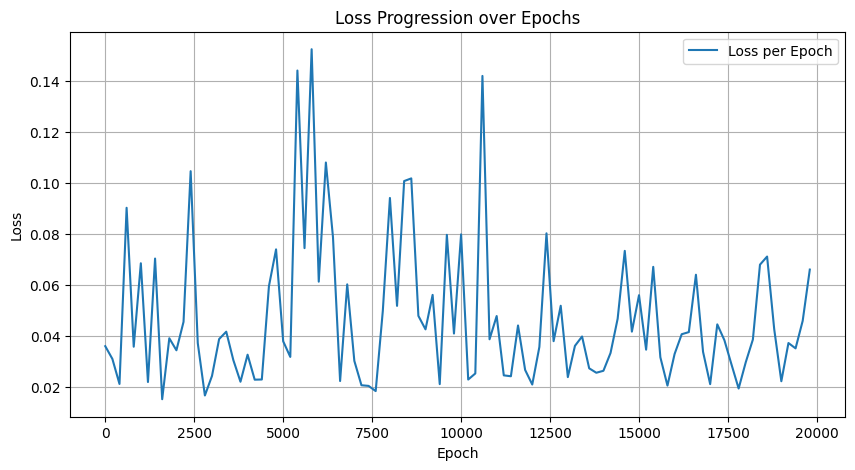

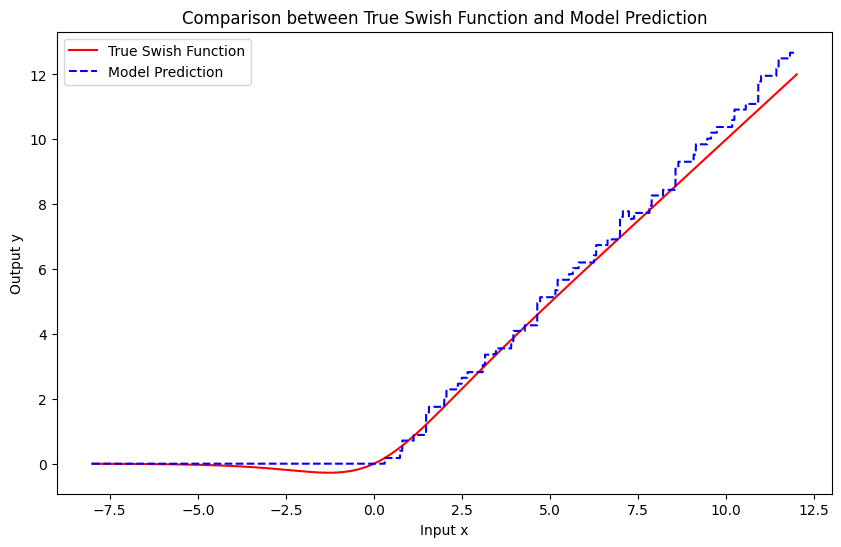

In [22]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 0.10661972314119339
Epoch 1001/20000, Loss: 0.11070051044225693
Epoch 2001/20000, Loss: 0.029353737831115723
Epoch 3001/20000, Loss: 0.018457142636179924
Epoch 4001/20000, Loss: 0.08255431801080704
Epoch 5001/20000, Loss: 0.023810219019651413
Epoch 6001/20000, Loss: 0.038030531257390976
Epoch 7001/20000, Loss: 0.062356092035770416
Epoch 8001/20000, Loss: 0.02951977588236332
Epoch 9001/20000, Loss: 0.05687008425593376
Epoch 10001/20000, Loss: 0.04146967828273773
Epoch 11001/20000, Loss: 0.047131866216659546
Epoch 12001/20000, Loss: 0.02509361132979393
Epoch 13001/20000, Loss: 0.027757421135902405
Epoch 14001/20000, Loss: 0.11715767532587051
Epoch 15001/20000, Loss: 0.062080711126327515
Epoch 16001/20000, Loss: 0.02763296104967594
Epoch 17001/20000, Loss: 0.05639393627643585
Epoch 18001/20000, Loss: 0.05030297860503197
Epoch 19001/20000, Loss: 0.03505011275410652
Loss values: [0.10661972314119339, 0.05763142555952072, 0.025482263416051865, 0.11111016571521759, 0.0697

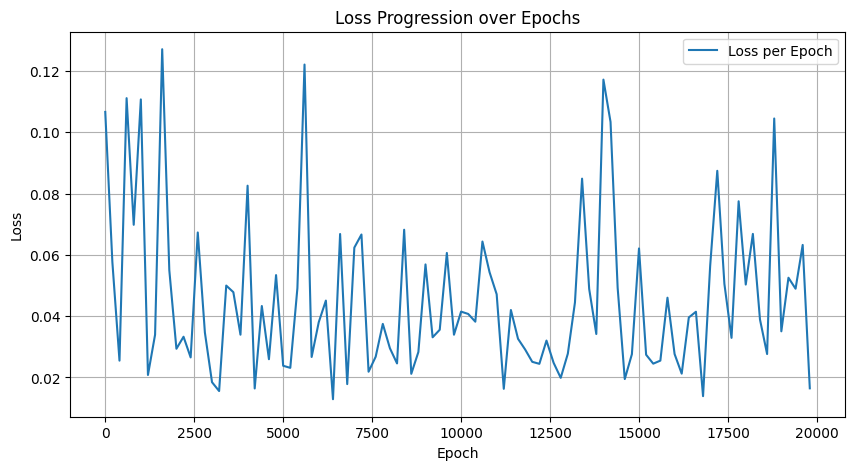

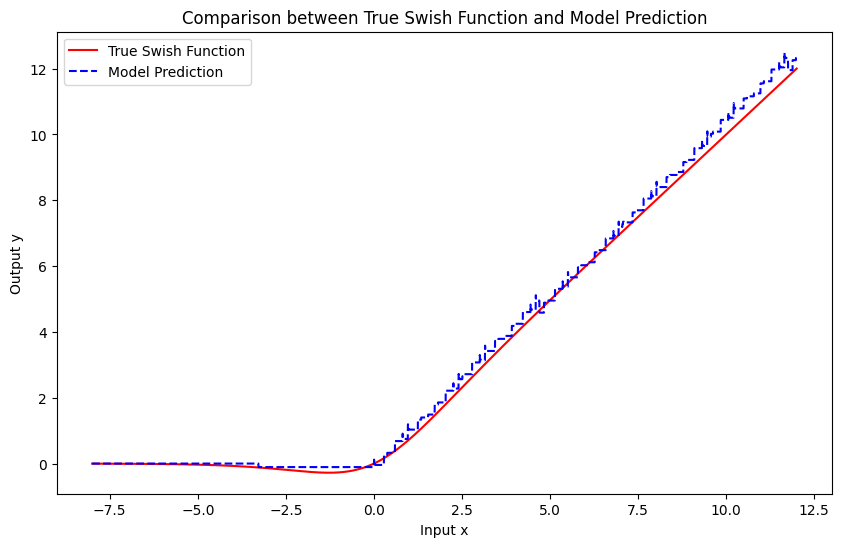

In [23]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 1.9089243412017822
Epoch 1001/20000, Loss: 0.03753545507788658
Epoch 2001/20000, Loss: 0.2329481691122055
Epoch 3001/20000, Loss: 0.05308569222688675
Epoch 4001/20000, Loss: 0.03853825107216835
Epoch 5001/20000, Loss: 0.1579691767692566
Epoch 6001/20000, Loss: 0.2256140410900116
Epoch 7001/20000, Loss: 0.023915190249681473
Epoch 8001/20000, Loss: 0.02325553260743618
Epoch 9001/20000, Loss: 0.06289681792259216
Epoch 10001/20000, Loss: 0.05159664899110794
Epoch 11001/20000, Loss: 0.02050727605819702
Epoch 12001/20000, Loss: 0.02978464588522911
Epoch 13001/20000, Loss: 0.03900310397148132
Epoch 14001/20000, Loss: 0.038201794028282166
Epoch 15001/20000, Loss: 0.09373371303081512
Epoch 16001/20000, Loss: 0.03894836828112602
Epoch 17001/20000, Loss: 0.03516409173607826
Epoch 18001/20000, Loss: 0.2035401165485382
Epoch 19001/20000, Loss: 0.14034180343151093
Loss values: [1.9089243412017822, 0.09196390956640244, 0.02840741164982319, 0.14206691086292267, 0.06309229135513306

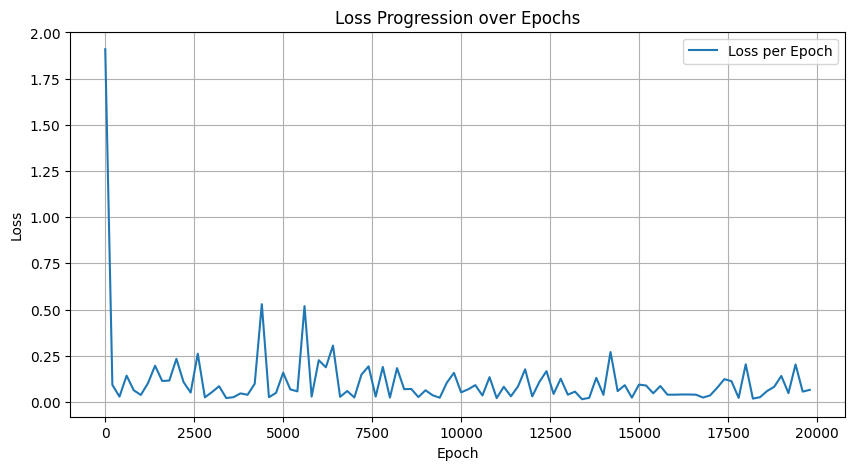

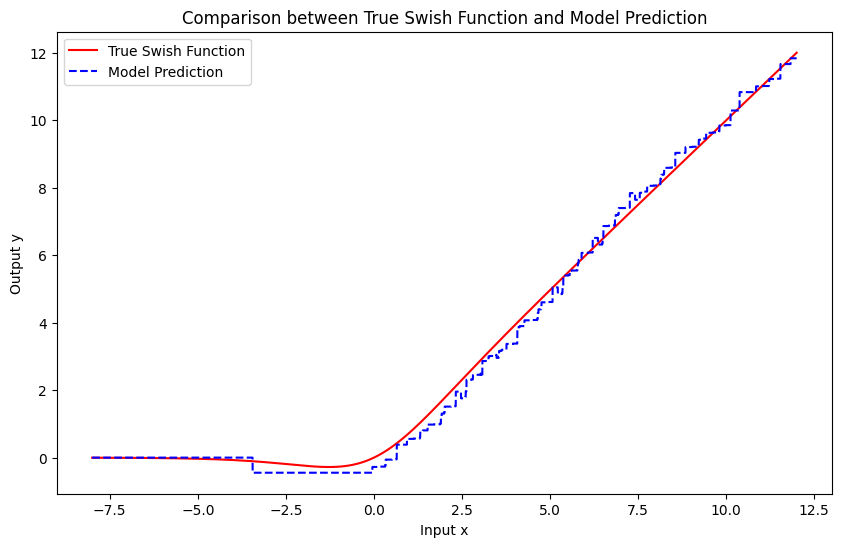

In [24]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()